# Sentiment Analysis

## Contents:
* 1. Dataset
    * 1.1. Loading Data
    * 1.2. Data Preprocessing
    * 1.3. Dataset Visualization
    * 1.4. Vectorization
* 2. Classifiers
    * 2.1. Naive Bayes Classfication
    * 2.2. K-Nearest Neighbour Classification
    * 2.3. Support Vector Machine (SVM) Classification
    * 2.4. Decision Tree Machine Classification
* 3. Training & Evaluation
    * 3.1. Subjectivity
    * 3.2. Polarity
* Advanced. Bert

In [278]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\ychen21\\Anaconda3\\Lib\\site-packages\\~ensorflow\\compiler\\tf2tensorrt\\_pywrap_py_utils.pyd'
Consider using the `--user` option or check the permissions.

  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\ychen21\Anaconda3\python.exe' 'C:\Users\ychen21\Anaconda3\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py' build_wheel 'C:\Users\ychen21\AppData\Local\Temp\tmpixfnmlsj'
       cwd: C:\Users\ychen21\AppData\Local\Temp\pip-install-ave5xubx\pycocotools_6d86e3d3b3ce4865a15c15299922fc82
  Complete output (16 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-39
  creating build\lib.win-amd64-cpython-39\pycocotools
  copying pycocotools\coco.py -> build\lib.win-amd64-cpython-39\pycocotools
  copying pycocotools\cocoeval.py -> build\lib.win-amd64-cpython-39\pycocotools
  copying pycocotool

In [ ]:
# Import libraries
import ast
import pandas as pd
import numpy as np
import regex as re
import string
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import random
from tqdm import tqdm
tqdm.pandas()

# preprocessing 
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from langdetect import detect
from langdetect import DetectorFactory
from imblearn.under_sampling import RandomUnderSampler

# word cloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
pd.options.mode.chained_assignment = None


from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Below are for Bert 

# keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer


# set seed for reproducibility
seed=42

## 1. Dataset Presentation

It is wise to explore our dataset first

### 1.1. Loading Data
Load necessary data.

In [ ]:
# Removing unused columns
df_outside = pd.read_csv('dataset_transformed.csv', encoding='latin')
df_crawl = pd.read_csv('compiled_tweets.csv')

# df_outside = pd.read_csv("/dbfs/FileStore/shared_uploads/dataset_transformed.csv", encoding='latin')
# df_crawl = pd.read_csv("/dbfs/FileStore/shared_uploads/compiled_tweets.csv", encoding='latin')
df_outside = df_outside[["Text", "Subjectivity", "Polarity"]]
df_crawl = df_crawl[["Text", "Subjectivity", "Polarity"]]
df_crawl = df_crawl[df_crawl['Subjectivity'].notna()].copy()
df = pd.concat([df_crawl, df_outside]).reset_index(drop=True)
df.info()

### 1.2. Data Preprocessing

As twitter texts are relatively unclean compared with others, special cleaning are applied to remove emojis and links

In [ ]:
# set seed
DetectorFactory.seed = 0

def language_detection(x:str):
    text = x.split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        except Exception as e:
            lang = "unknown"
            pass
    return lang

In [ ]:
df['Language'] = df['Text'].progress_apply(language_detection)

In [ ]:
#plot the distribution of language
fig = plt.figure(figsize=(15, 5))
sns.histplot(data=df['Language'])
plt.title("Distribution of Language")
plt.show()

In [ ]:
df = df[df['Language'] == 'en'].copy()

In [ ]:
def clean_text(text):
    text = str(text)
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'^RT[\s]+', '', text)
    # text = re.sub(r'pic.twitter\S+', ' ', text)
    text = re.sub(r'#', '', text)
    text = text.lower()

    return text

def decontracted(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"it\'s", "it is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\“", "", text)
    text = re.sub(r"\”", "", text)
    text = re.sub(r"\…", "", text)

    return text


def remove_punc(tweet):
    tweet =  tweet.translate(str.maketrans('', '', string.punctuation))
    tweet = ' '.join([word for word in tweet.split()])
    tweet = tweet.lower()
    
    return tweet

In [ ]:
df['Text'] = df['Text'].progress_apply(clean_text).apply(decontracted).apply(remove_punc)
df.head()

#### Stemming

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

def stem_text(x):
    stemmer = PorterStemmer()
    x = word_tokenize(x)
    stem = ''
    
    for i in x:
        stem += stemmer.stem(i) + ' '
        
    return stem

df['stemmed_text'] = df['Text'].progress_apply(stem_text)
df.head()

#### Lemmatization

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

def lemmatize_text(corpus):
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in tweet.split()]) for tweet in corpus]

df['lemmatized_text'] = lemmatize_text(df['Text'])
df.head()

#### Stopwords Removal

In [ ]:
stop = stopwords.words('english')
additional_stopwords = ["'s","...","'ve","``","''","'m",'--',"'ll","'d", 'u', 'b', 'c', 'd', 'x', 'xf', 'f', 'p', 'xb']
stop = set(stop + additional_stopwords)

def remove_stopwords(x):
    x = word_tokenize(x)
    store_words = ''
    
    for i in x:
        if i not in stop:
            store_words += i + ' '
            
    return store_words

In [ ]:
df['cleaned_text'] = df['Text'].progress_apply(remove_stopwords)
df['cleaned_stemmed_text'] = df['stemmed_text'].progress_apply(remove_stopwords)
df['cleaned_lemmatized_text'] = df['lemmatized_text'].progress_apply(remove_stopwords)

df.head()

### 1.3. Data Visualization

In [ ]:
print("========== number of words in the corpus ==========")

print(f"original: {df['Text'].apply(lambda x: len(x.split())).sum()}")

print(f"after stemming: {df['stemmed_text'].apply(lambda x: len(x.split())).sum()}")

print(f"after lemmatization: {df['lemmatized_text'].apply(lambda x: len(x.split())).sum()}")

print(f"after removal of stopwords: {df['cleaned_text'].apply(lambda x: len(x.split())).sum()}")

print(f"after stemming and removal of stopwords: {df['cleaned_stemmed_text'].apply(lambda x: len(x.split())).sum()}")

print(f"after lemmatization and removal of stopwords: {df['cleaned_lemmatized_text'].apply(lambda x: len(x.split())).sum()}")

In [ ]:
num_words_train = df['cleaned_lemmatized_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12,6))
p1=sns.kdeplot(df['cleaned_lemmatized_text'].apply(lambda x: len(x.split())), fill=True, color="r").set_title('Distribution of Number of Words in Corpus (After Lemmatization and Removal of Stopwords)')

In [ ]:
word_list_train = df.cleaned_lemmatized_text.str.split()
top = Counter([item for sublist in word_list_train for item in sublist])
temp = pd.DataFrame(top.most_common(15))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

In [ ]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):

    wordcloud = WordCloud(background_color=color,
                    stopwords = STOPWORDS,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = seed,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()

In [ ]:
pos_mask = np.array(Image.new('RGB', (1000,600)))
plot_wordcloud(word_list_train, mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Corpus")

### 1.4. Vectorization

In [ ]:
# don't consider uncleaned text for now (too much noise)
preprocessings = ['cleaned_stemmed_text', 'cleaned_lemmatized_text', 'cleaned_text'] 

In [ ]:
sub_df = df[df['Subjectivity'].notna()].copy()
sub_df = sub_df.dropna(subset=preprocessings)
sub_df['Subjectivity'].value_counts()

We can see that here the class is highly unbalanced with too many biased content. For better output, we need to balance the dataset first

In [ ]:
#  Random oversampling involves randomly selecting examples from the minority class, with replacement, and adding them to the training dataset.
sampler = RandomUnderSampler(random_state=seed)
X_sub, Y_sub = sampler.fit_resample(sub_df[preprocessings], sub_df['Subjectivity'])
Y_sub.value_counts()

In [ ]:
# do the same for 'Polarity'
polar_df = df[df['Polarity'].notna()].copy()
polar_df = polar_df.dropna(subset=preprocessings)
polar_df['Polarity'].value_counts()

In [ ]:
X_polar, Y_polar = sampler.fit_resample(polar_df[preprocessings], polar_df['Polarity'])
Y_polar.value_counts()

<b> Train, test, cv split </b>

In [ ]:
# for subjectivity, get train set, valid set (cross validation), andn test set
X_train_valid_sub, X_test_sub, y_train_valid_sub, y_test_sub = train_test_split(X_sub, 
                                                    Y_sub,
                                                    test_size = 0.2, 
                                                    random_state = seed, stratify=Y_sub)
X_train_sub, X_valid_sub, y_train_sub, y_valid_sub = train_test_split(X_train_valid_sub, 
                                                    y_train_valid_sub,
                                                    test_size = 0.2, 
                                                    random_state = seed, stratify=y_train_valid_sub)

print(f"Shape of X_train: {X_train_sub.shape}")
print(f"Shape of y_train: {y_train_sub.shape}")
print(f"Shape of X_valid: {X_valid_sub.shape}")
print(f"Shape of y_valid: {y_valid_sub.shape}")
print(f"Shape of X_test: {X_test_sub.shape}")
print(f"Shape of y_test: {y_test_sub.shape}")

In [ ]:
# for polarity, get train set, valid set (cross validation), andn test set
X_train_valid_polar, X_test_polar, y_train_valid_polar, y_test_polar = train_test_split(X_polar, 
                                                    Y_polar,
                                                    test_size = 0.3, 
                                                    random_state = seed, stratify=Y_polar)
X_train_polar, X_valid_polar, y_train_polar, y_valid_polar = train_test_split(X_train_valid_polar, 
                                                    y_train_valid_polar,
                                                    test_size = 0.1, 
                                                    random_state = seed, stratify=y_train_valid_polar)

print(f"Shape of X_train: {X_train_polar.shape}")
print(f"Shape of y_train: {y_train_polar.shape}")
print(f"Shape of X_valid: {X_valid_polar.shape}")
print(f"Shape of y_valid: {y_valid_polar.shape}")
print(f"Shape of X_test: {X_test_polar.shape}")
print(f"Shape of y_test: {y_test_polar.shape}")

In [ ]:
vec_X_train_sub = {}
vec_X_valid_sub = {}
vec_X_test_sub = {}
# The CountVectorizer will select the words/features/terms which occur the most frequently. It takes absolute values so if you set the 'max_features = 3', it will select the 3 most common words in the data.
for method in preprocessings:
    clf = CountVectorizer(ngram_range=(1,2), max_features=500).fit(X_train_sub[method])
    X_train_cv =  clf.transform(X_train_sub[method])
    X_valid_cv = clf.transform(X_valid_sub[method])
    X_test_cv = clf.transform(X_test_sub[method])
    
    tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
    vec_X_train_sub[method] = tf_transformer.transform(X_train_cv)
    vec_X_valid_sub[method] = tf_transformer.transform(X_valid_cv)
    vec_X_test_sub[method] = tf_transformer.transform(X_test_cv)

In [ ]:
vec_X_train_polar = {}
vec_X_valid_polar = {}
vec_X_test_polar = {}

for method in preprocessings:
    clf = CountVectorizer(ngram_range=(1,2), max_features=500).fit(X_train_polar[method])
    X_train_cv =  clf.transform(X_train_polar[method])
    X_valid_cv = clf.transform(X_valid_polar[method])
    X_test_cv = clf.transform(X_test_polar[method])
    
    tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
    vec_X_train_polar[method] = tf_transformer.transform(X_train_cv)
    vec_X_valid_polar[method] = tf_transformer.transform(X_valid_cv)
    vec_X_test_polar[method] = tf_transformer.transform(X_test_cv)

## 2. Classifiers

### 2.1. Naive Bayes Classification

In [ ]:
def naiveBayesClassification(x_train, x_test, y_train, y_test, preprocessing):

    naiveBayes_model = MultinomialNB().fit(x_train, y_train)
    result = naiveBayes_model.predict(x_test)
    confuse = metrics.confusion_matrix(y_test, result)
    
    
    # ==================================================
    # Confusion Matrix
    # ==================================================
    
    fig = plt.figure()
    sns.heatmap(confuse, annot = True, fmt='d')
    
    print("==================================================")
    print("Model: Naive Bayes Classification")
    print("Preprocessing Function: ", preprocessing)
    print("==================================================")
    print()
    plt.title("Confusion matrix of Naive Bayes Classification of Tweets")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score = metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)
    
    print("------------ Evaluation Metrics ----------------")
    print()
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print()

### 2.2. K-Nearest Neighbour (KNN) Classification

In [ ]:
def KNNClassification(x_train, x_valid, x_test, y_train, y_valid, y_test, preprocessing, best_params=None):

    if best_params is None:
        
        print("Searching for best parameters")

        metric = ['euclidean', 'manhattan', 'cosine']
        neighbors = list(range(1,30))
        leaf_size = list(range(1,50))
        weight = ['uniform', 'distance']
        param_grid = {'metric' : metric, 'n_neighbors': neighbors, 'weights' : weight, 'leaf_size' : leaf_size}
        
        grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3)
        grid_search.fit(x_valid, y_valid)

        best_params = grid_search.best_params_
    
    
    knn_model = KNeighborsClassifier(n_neighbors = best_params['n_neighbors'], metric= best_params['metric'], leaf_size = best_params['leaf_size'], weights = best_params['weights'])
    knn_model.fit(x_train, y_train)   
    
    result = knn_model.predict(x_test)
    confuse = metrics.confusion_matrix(y_test, result)
    
    # ==================================================
    # Confusion Matrix
    # ==================================================
    
    fig = plt.figure()
    sns.heatmap(confuse, annot = True, fmt='d')
    
    print("==================================================")
    print("Model: K-Nearest Neighbour Classification")
    print("Best parameters:", best_params)
    print("Preprocessing Function: ", preprocessing)
    print("==================================================")
    print()
    plt.title("Confusion matrix of KNN Classification of tweets")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    
    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score= metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)

    print("------------ Evaluation Metrics ----------------")
    print()
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print()
  

### 2.3. Support Vector Machine (SVM) Classification

In [ ]:
def SVMClassification(x_train, x_valid, x_test, y_train, y_valid, y_test, preprocessing, best_params=None):

    if best_params is None:
        
        print("Searching for best parameters")

        Cs = [0.001, 0.01, 0.1, 1, 10]
        gammas = [0.05, 0.1, 0.15, 0.20, 0.25]
        degrees = [0, 1, 2, 3, 4, 5, 6]
        kernels = ['rbf', 'linear', 'poly']
        param_grid = {'C': Cs, 'gamma' : gammas, 'degree' : degrees, 'kernel' : kernels}
        
        grid_search = GridSearchCV(svm.SVC(), param_grid, cv = 3)
        grid_search.fit(x_valid, y_valid)

        best_params = grid_search.best_params_

    SVM_model = svm.SVC(C = best_params['C'], kernel = best_params['kernel'], gamma = best_params['gamma'], degree = best_params['degree'], random_state=seed)
    SVM_model.fit(x_train, y_train)
    
    result = SVM_model.predict(x_test)
    confuse = metrics.confusion_matrix(y_test, result)
    
    
    # ==================================================
    # Confusion Matrix
    # ==================================================
    fig = plt.figure()
    sns.heatmap(confuse, annot = True, fmt='d')
    
    print("==================================================")
    print("Model: Support Vector Machine Classification")
    print("Preprocessing Function: ", preprocessing)
    print("Best parameters:", best_params)
    print("==================================================")
    print()
    plt.title("Confusion matrix of SVM Classification of Tweets")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    
    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score= metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)

    print("------------ Evaluation Metrics ----------------")
    print()
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print()

### 2.4. Decision Tree Classification

In [ ]:
def decisionTreeClassification(x_train, x_valid, x_test, y_train, y_valid, y_test, preprocessing, best_params=None):
    
    clf = DecisionTreeClassifier() 

    if best_params is None:
            
        print("Searching for best parameters")
        param_grid = { 
            'criterion': ['gini','entropy'],
            'splitter': ['best','random'],
            'max_features': ['sqrt','log2']
        }
        
        grid_search = GridSearchCV(clf, param_grid, cv= 3)
        grid_search.fit(x_valid, y_valid)
        best_params = grid_search.best_params_

    decisionTree_model = DecisionTreeClassifier(criterion = best_params['criterion'],splitter = best_params['splitter'], max_features = best_params['max_features'], random_state=seed)
    decisionTree_model.fit(x_train, y_train)

    result = decisionTree_model.predict(x_test)
    confuse = metrics.confusion_matrix(y_test, result)


    # ==================================================
    # Confusion Matrix
    # ==================================================
    
    fig = plt.figure()
    sns.heatmap(confuse, annot = True, fmt='d')
    
    print("==================================================")
    print("Model: Decision Tree Classification")
    print("Preprocessing Function: ", preprocessing)
    print("Best parameters:", best_params)
    print("==================================================")
    print()
    plt.title("Confusion matrix of Decision Tree Classification of Tweets")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score= metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)

    print("------------ Evaluation Metrics ----------------")
    print()
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print()

## 3. Training

### 3.1. Subjectivity Classification & Evaluation 

We use naive bayes model's performance as the baseline for measurements of other models.

In [ ]:
best_params_df = pd.read_csv("best_params.csv")

In [ ]:
def get_best_params(model_name: str, task: str, src:str):
    param = best_params_df[(best_params_df['model'] == model_name) & (best_params_df['task']==task) & (best_params_df['input'] == src)]['best_params'].values[0]
    try:
        return ast.literal_eval(param)
    except:
        return None

In [ ]:
def base_line_performance(processing_idx:int, task: str):
    print("Base line")
    method = preprocessings[processing_idx]
    if task == 'subjectivity':
        x_train = vec_X_train_sub[method]
        x_test = vec_X_test_sub[method]
        y_train = y_train_sub
        y_test = y_test_sub
    else:
        x_train = vec_X_train_polar[method]
        x_test = vec_X_test_polar[method]
        y_train = y_train_polar
        y_test = y_test_polar
        
    naiveBayesClassification(x_train, x_test, y_train, y_test, method)

In [ ]:
def classifier_performance(processing_idx:int, task: str):
    method = preprocessings[processing_idx]
    if task == 'subjectivity':
        x_train = vec_X_train_sub[method]
        x_valid = vec_X_valid_sub[method]
        x_test = vec_X_test_sub[method]
        y_train = y_train_sub
        y_valid = y_valid_sub
        y_test = y_test_sub
    else:
        x_train = vec_X_train_polar[method]
        x_valid = vec_X_valid_polar[method]
        x_test = vec_X_test_polar[method]
        y_train = y_train_polar
        y_valid = y_valid_polar
        y_test = y_test_polar

    decisionTreeClassification(
        x_train,
        x_valid,
        x_test,
        y_train,
        y_valid,
        y_test,
        method, 
        get_best_params('DecisionTree', task, method))

    SVMClassification(
        x_train,
        x_valid,
        x_test,
        y_train,
        y_valid,
        y_test,
        method, 
        get_best_params('SVM', task, method)
    )

    KNNClassification(
        x_train,
        x_valid,
        x_test,
        y_train,
        y_valid,
        y_test,
        method, 
        get_best_params('KNN', task, method)
    )

#### 3.1.1 Subjectivity with Cleaned Stemmed Text
Compare what we have with baseline model (Naive Bayes)

In [ ]:
base_line_performance(0,'subjectivity')

In [ ]:
classifier_performance(0,'subjectivity')

#### 3.1.2 Subjectivity with Cleaned Lemmatized Text 
Compare what we have with baseline model (Naive Bayes)

In [ ]:
base_line_performance(1,'subjectivity')

In [ ]:
classifier_performance(1,'subjectivity')

#### 3.1.3 Subjectivity with Cleaned Text 
Compare what we have with baseline model (Naive Bayes)

In [ ]:
base_line_performance(2, 'subjectivity')

In [ ]:
classifier_performance(2, 'subjectivity')

### 3.2. Polarity Classification & Evaluation 

We use naive bayes model's performance as the baseline for measurements of other models.

#### 3.2.1 Polarity with Cleaned Stemmed Text
Compare what we have with baseline model (Naive Bayes)

In [ ]:
base_line_performance(0,'polarity')

In [ ]:
classifier_performance(0,'polarity')

#### 3.2.2 Polarity with Cleaned Lemmatized Text
Compare what we have with baseline model (Naive Bayes)

In [ ]:
base_line_performance(1,'polarity')

In [ ]:
classifier_performance(1,'polarity')

#### 3.2.3 Polarity with Cleaned Text 
Compare what we have with baseline model (Naive Bayes)

In [ ]:
base_line_performance(2, 'polarity')

In [ ]:
classifier_performance(2, 'polarity')

## Innovation: Traditionoal Classifiers vs Bert

Reference:
https://www.tensorflow.org/text/tutorials/classify_text_with_bert#evaluate_the_model

In [ ]:
import keras.backend as K
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(5,5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

In [ ]:
checkpoint_path_sub = "training_sub/cp.ckpt"
checkpoint_dir_sub = os.path.dirname(checkpoint_path_sub)
checkpoint_path_polar = "training_polar/cp.ckpt"
checkpoint_dir_polar = os.path.dirname(checkpoint_path_polar)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

<a id="3.1"></a>
[<font size="+1" ><b>Subjectivity</b></font><br>](#0)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


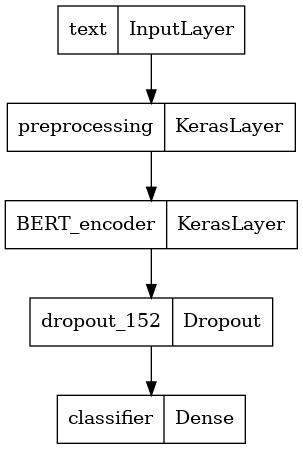

In [ ]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

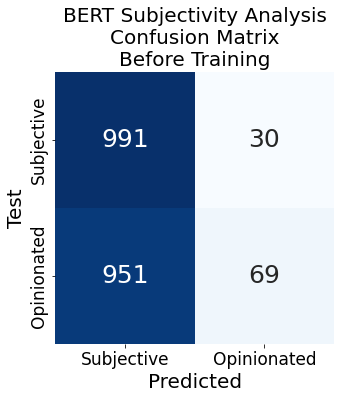

In [ ]:
bert_raw_result = classifier_model(tf.constant(list(X_test_sub['cleaned_text'])))
conf_matrix(y_test_sub.astype(bool), K.round(tf.sigmoid(bert_raw_result)),'BERT Subjectivity Analysis\nConfusion Matrix\nBefore Training', ['Subjective', 'Opinionated'])

In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test_sub,K.round(tf.sigmoid(bert_raw_result)), target_names=['Subjective', 'Opinionated']))

	Classification Report for BERT:

               precision    recall  f1-score   support

  Subjective       0.51      0.97      0.67      1021
 Opinionated       0.70      0.07      0.12      1020

    accuracy                           0.52      2041
   macro avg       0.60      0.52      0.40      2041
weighted avg       0.60      0.52      0.40      2041



## Training Bert Model

#### Getting Dataset

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

batch_size=32
epochs=7
steps_per_epoch = len(X_train_sub['cleaned_text'])/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

print(f'Training model with {tfhub_handle_encoder}')

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_sub,
                                                    save_weights_only=True,
                                                    verbose=1)
history = classifier_model.fit(np.array(X_train_sub['cleaned_text']), y_train_sub, 
                               validation_data=(np.array(X_valid_sub['cleaned_text']), y_valid_sub), 
                               epochs=epochs, batch_size=batch_size, callbacks=[cp_callback])  # Pass callback to training

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
134/134 [==============================] - 28s 179ms/step - loss: 0.5150 - binary_accuracy: 0.7306 - val_loss: 0.5631 - val_binary_accuracy: 0.7191
Epoch 2/5
134/134 [==============================] - 24s 178ms/step - loss: 0.4516 - binary_accuracy: 0.7750 - val_loss: 0.5740 - val_binary_accuracy: 0.7107
Epoch 3/5
134/134 [==============================] - 24s 179ms/step - loss: 0.3711 - binary_accuracy: 0.8282 - val_loss: 0.6114 - val_binary_accuracy: 0.6709
Epoch 4/5
134/134 [==============================] - 24s 179ms/step - loss: 0.3035 - binary_accuracy: 0.8595 - val_loss: 0.6229 - val_binary_accuracy: 0.7086
Epoch 5/5
134/134 [==============================] - 24s 176ms/step - loss: 0.2587 - binary_accuracy: 0.8898 - val_loss: 0.6507 - val_binary_accuracy: 0.6897


In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
loss, accuracy = classifier_model.evaluate(np.array(X_test_sub['cleaned_text']), y_test_sub)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

64/64 [==============================] - 6s 95ms/step - loss: 0.7212 - binary_accuracy: 0.6957
Loss: 0.7212352156639099
Accuracy: 0.695737361907959


In [ ]:
y_pred_after_train = classifier_model.predict(np.array(X_test_sub['cleaned_text']))

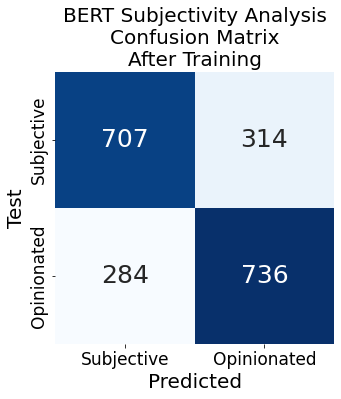

In [ ]:
conf_matrix(y_test_sub.astype(bool), K.round(tf.sigmoid(y_pred_after_train)),'BERT Subjectivity Analysis\nConfusion Matrix\nAfter Training', ['Subjective', 'Opinionated'])

In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test_sub,K.round(tf.sigmoid(y_pred_after_train), target_names=['Subjective', 'Opinionated'])))

In [ ]:
# save the model for future use
classifier_model.save('./bert_subjectivity_model', include_optimizer=False)